Testando edit Roberto github command line / agora no site do github

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.signal as signal
from pathlib import Path
from scipy.spatial.distance import euclidean
from scipy.signal import medfilt
from scipy.signal import sosfiltfilt, butter

import sys
sys.path.append("../src")
from conversion_mat_to_py import mat2dict, pretty_dict, matobj2dict, dict2ntuple, name_data
from sources_cv2 import defineStartEnd, count_frames
from save_datas import save_data
from data_conversions import acc_to_angle
from filters import filter_butter
from fast_open_data import open_data_filter

# -> Escolher voluntário e chave

* open_data_filter(Voluntary => 1 até 90, key => 'S1_Synched', 'S2_Synched', 'I1', 'I2', 'S1', 'S2' ...)

In [2]:
S, L, R = open_data_filter(52, key = 'S1_Synched')

In [3]:
# dados para voluntário 52
estimated_R = [ 30, 330, 585, 740]
estimated_L = [ 100, 330, 595, 790]
estimated_S = [ 140, 264, 365, 570, 647, 725]

sequece_R_L = [1,2,1,3,1]
sequece_S = [1,2,3,1,2,3,1]

In [4]:
sequence = sequece_S.copy()
sequence.extend(sequece_R_L) 
classes = np.unique(sequence)

In [5]:
def sep_modo(data, estimated_data, modo_sequence, classes):
    
    
    V_seq = np.zeros(len(modo_sequence))
    Var_seq = np.zeros(len(modo_sequence))
    V_modo = np.zeros(len(classes))
    Var_modo = np.zeros(len(classes))
    
    modo = np.zeros((data.shape))

    for i in range(len(modo_sequence)):
        if i == 0:
            modo[:estimated_data[i]] = modo_sequence[i]
            V_seq[i] = np.mean(np.diff(data[:estimated_data[i]]))
            Var_seq[i] = np.var(np.diff(data[:estimated_data[i]]))
            
            
        elif i == (len(estimated_data)):
            modo[estimated_data[i-1]:] = modo_sequence[i]
            V_seq[i] = np.mean(np.diff(data[estimated_data[i-1]:]))
            Var_seq[i] = np.var(np.diff(data[estimated_data[i-1]:]))
        
        else:
            modo[estimated_data[i-1]:estimated_data[i]] = modo_sequence[i]
            V_seq[i] = np.mean(np.diff(data[estimated_data[i-1]:estimated_data[i]]))
            Var_seq[i] = np.var(np.diff(data[estimated_data[i-1]:estimated_data[i]]))
                    
    for n in range(len(classes)):
        idx = np.where(np.array(modo_sequence) == n+1)[0]
        V_modo[n] = np.mean(np.array(V_seq)[idx])
        Var_modo[n] = np.mean(np.array(Var_seq)[idx])
        
    return modo, V_seq, V_modo, Var_seq, Var_modo
            

In [6]:
modo, V_seq, V_modo, Var_seq, Var_modo = sep_modo(S, estimated_S, sequece_S, classes)

O sinal do movimento está na escala de 0 à 3 para facilitar a visualização dos modos em relação ao sinal.

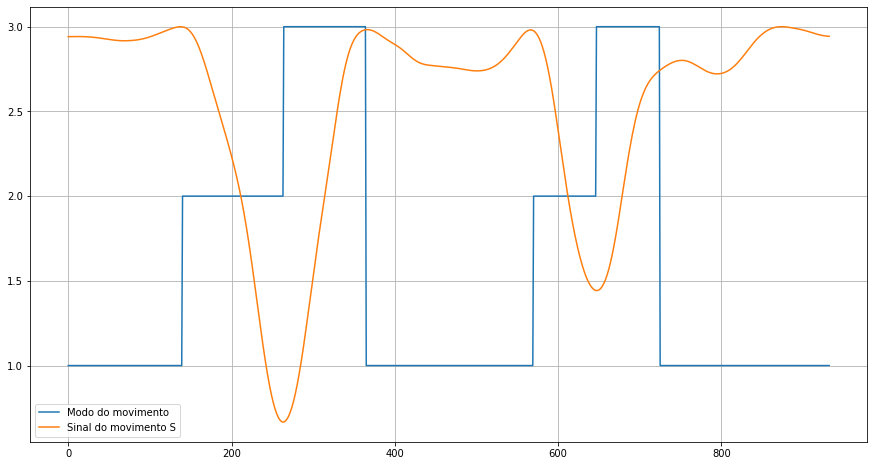

In [7]:
plt.figure(figsize=[15,8])
plt.plot(modo, label = 'Modo do movimento')
plt.plot(S/max(S)*3, label = 'Sinal do movimento S')
plt.legend()
plt.grid()
plt.show()

In [8]:
for i in range(len(V_seq)):
    print('Modo: ', sequece_S[i], '--> Média: ', round(V_seq[i], 4))
    
for i in range(len(Var_seq)):
    print('Modo: ', sequece_S[i], '--> Variância: ', round(Var_seq[i], 4))

Modo:  1 --> Média:  0.0117
Modo:  2 --> Média:  -0.5316
Modo:  3 --> Média:  0.649
Modo:  1 --> Média:  -0.0006
Modo:  2 --> Média:  -0.5651
Modo:  3 --> Média:  0.4725
Modo:  1 --> Média:  0.027
Modo:  1 --> Variância:  0.0007
Modo:  2 --> Variância:  0.0749
Modo:  3 --> Variância:  0.106
Modo:  1 --> Variância:  0.0073
Modo:  2 --> Variância:  0.0758
Modo:  3 --> Variância:  0.0765
Modo:  1 --> Variância:  0.0058


Aplicando as médias para cada uma das fases dos movimentos, temos que: 

In [9]:
for i in range(len(V_modo)):
    print('Modo: ', classes[i], '--> Média: ', round(V_modo[i], 4))

for i in range(len(Var_modo)):
    print('Modo: ', classes[i], '--> Variância: ', round(Var_modo[i], 4))

Modo:  1 --> Média:  0.0127
Modo:  2 --> Média:  -0.5484
Modo:  3 --> Média:  0.5607
Modo:  1 --> Variância:  0.0046
Modo:  2 --> Variância:  0.0754
Modo:  3 --> Variância:  0.0912


In [10]:
def generate_model(data, modo, V_modo):
    
    data_model = np.zeros(S.shape)
    for i in range(len(data)):
        if i == 0:
            data_model[i] = data[i]
        else:
            data_model[i] = data[i-1] + V_modo[int(modo[i])-1]
    
    return data_model

In [11]:
data_model = generate_model(S, modo, V_modo)

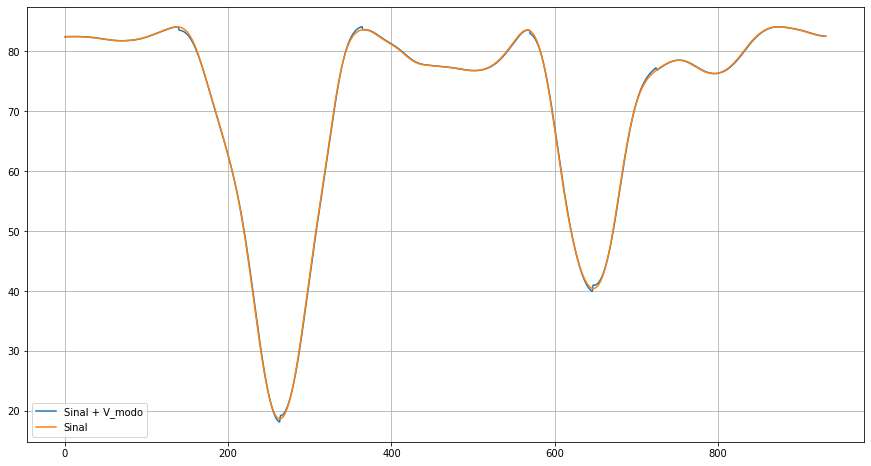

In [12]:
plt.figure(figsize=[15,8])
plt.plot(data_model, label = 'Sinal + V_modo')
plt.plot(S, label = 'Sinal')
plt.legend()
plt.grid()
plt.show()

Separando os modos para os dados de Spine

# Aplicar filtro de Kalman

In [13]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import time

In [14]:
def filter_kalman(data, vel, var, c):

    if c == 1:
        my_filter = KalmanFilter(dim_x=2, dim_z=1)

        my_filter.x = np.array([data[0],vel])       # initial state (location and velocity)

        my_filter.F = np.array([[1.,1.], [0.,1.]])    # state transition matrix

        my_filter.H = np.array([[1.,0.]])    # Measurement function
        my_filter.P *= 1000.                 # covariance matrix
        my_filter.R = 5                      # state uncertainty
        my_filter.Q = Q_discrete_white_noise(2, 1, var) # process uncertainty
        
    elif c == 2:
        my_filter = KalmanFilter(dim_x=2, dim_z=1)

        my_filter.x = np.array([data[0],vel])       # initial state (location and velocity)

        my_filter.F = np.array([[1.,1.], [0.,1.]])    # state transition matrix

        my_filter.H = np.array([[1.,0.]])    # Measurement function
        my_filter.P *= 1000.                 # covariance matrix
        my_filter.R = 5                      # state uncertainty
        my_filter.Q = Q_discrete_white_noise(2, 1, var) # process uncertainty
        
    else:
        my_filter = KalmanFilter(dim_x=2, dim_z=1)

        my_filter.x = np.array([data[0],vel])       # initial state (location and velocity)

        my_filter.F = np.array([[1.,1.], [0.,1.]])    # state transition matrix

        my_filter.H = np.array([[1.,0.]])    # Measurement function
        my_filter.P *= 1000.                 # covariance matrix
        my_filter.R = 5                      # state uncertainty
        my_filter.Q = Q_discrete_white_noise(2, 1, var) # process uncertainty
        
    i = 0
    data_out = np.zeros(data.shape)
    while i < len(data):
        my_filter.predict()
        my_filter.update(data[i])
        
        # do something with the output
        x = my_filter.x
        data_out[i] = x[0]
        i = i + 1
        
    return data_out

In [15]:
S_filter = np.zeros(S.shape)

i = 0
j = 0
S_sep = []
for n in range(len(classes)):
    S_sep.append([])
while j < len(modo):
    i = j 
    cur_class = modo[i].astype(int)
    
    while modo[j] == cur_class:
        j += 1
        if j >= len(S):
            j = len(S)
            break
            
    idx = np.where(classes==cur_class)[0][0]
    S_sep[idx].append(S[i:j])
    
    S_filter[i:j] = filter_kalman(S[i:j], V_modo[idx], Var_modo[idx], cur_class)

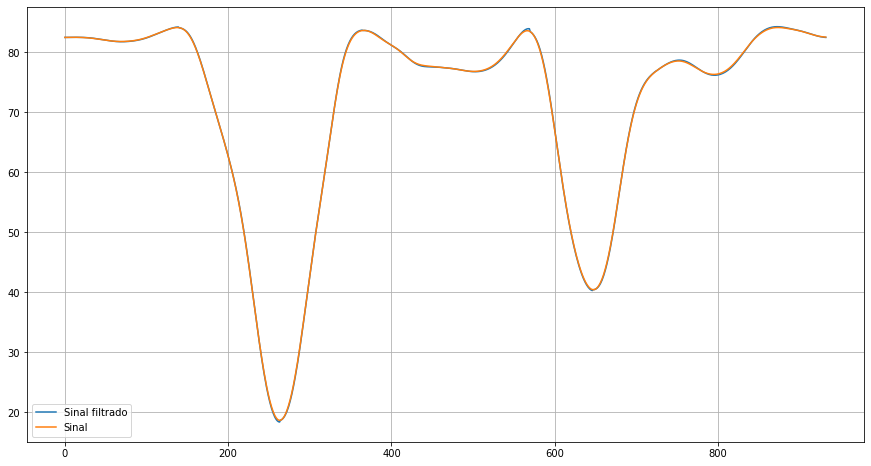

In [16]:
plt.figure(figsize=[15,8])
plt.plot(S_filter, label = 'Sinal filtrado')
plt.plot(S, label = 'Sinal')
plt.legend()
plt.grid()
plt.show()